
# SOCIAL MEDIA SENTIMENT ANALYSIS


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from wordcloud import WordCloud
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

In [2]:
# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (classification_report, confusion_matrix, 
                             accuracy_score, f1_score)
from sklearn.feature_extraction.text import TfidfVectorizer


In [3]:
# Set visualization style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

In [4]:
# Download NLTK resources
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)

True

## Load and Explore Data

In [5]:
df = pd.read_csv("sentiment_dataset.csv")
df.head(5)

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


In [6]:
df.shape

(732, 15)

In [7]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'Text', 'Sentiment', 'Timestamp', 'User',
       'Platform', 'Hashtags', 'Retweets', 'Likes', 'Country', 'Year', 'Month',
       'Day', 'Hour'],
      dtype='object')

In [8]:
# df.dtypes.values
df.dtypes

Unnamed: 0.1      int64
Unnamed: 0        int64
Text             object
Sentiment        object
Timestamp        object
User             object
Platform         object
Hashtags         object
Retweets        float64
Likes           float64
Country          object
Year              int64
Month             int64
Day               int64
Hour              int64
dtype: object

In [9]:
# df.isnull().sum().value
df.isnull().sum()

Unnamed: 0.1    0
Unnamed: 0      0
Text            0
Sentiment       0
Timestamp       0
User            0
Platform        0
Hashtags        0
Retweets        0
Likes           0
Country         0
Year            0
Month           0
Day             0
Hour            0
dtype: int64

In [10]:
# Percentage of Null Values
print(f"Missing Percentage {(df.isnull().sum().values/df.shape[0] * 100).round(2)}")

Missing Percentage [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [11]:
df.describe()

,Unnamed: 0.1,Unnamed: 0,Retweets,Likes,Year,Month,Day,Hour
count,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000,732.000000
mean,366.464481,369.740437,21.508197,42.901639,2020.471311,6.122951,15.497268,15.521858
std,211.513936,212.428936,7.061286,14.089848,2.802285,3.411763,8.474553,4.113414
min,0.000000,0.000000,5.000000,10.000000,2010.000000,1.000000,1.000000,0.000000
25%,183.750000,185.750000,17.750000,34.750000,2019.000000,3.000000,9.000000,13.000000
50%,366.500000,370.500000,22.000000,43.000000,2021.000000,6.000000,15.000000,16.000000
75%,549.250000,553.250000,25.000000,50.000000,2023.000000,9.000000,22.000000,19.000000
max,732.000000,736.000000,40.000000,80.000000,2023.000000,12.000000,31.000000,23.000000


In [12]:
df['Sentiment'].value_counts()

Sentiment
Positive         44
Joy              42
Excitement       32
Neutral          14
Contentment      14
                 ..
Triumph           1
Heartwarming      1
Obstacle          1
Sympathy          1
Pressure          1
Name: count, Length: 279, dtype: int64

## 🧹 Data Cleaning Process...

In [13]:
# Clean string columns
string_cols = ['Text', 'Sentiment', 'User', 'Platform', 'Hashtags', 'Country']
for col in string_cols:
    if col in df.columns:
        df[col] = df[col].str.strip()

In [14]:
# Remove Unnecessary Columns
columns_to_drop = ['Unnamed: 0.1', 'Unnamed: 0', 'Hashtags', 'Day', 'Hour', 'Sentiment']
df = df.drop(columns = [col for col in columns_to_drop if col in df.columns])
df.head(4)

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1
3,Excited about the upcoming weekend getaway!,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1


In [15]:
# Clean platform and country names
df['Platform'] = df['Platform'].str.strip()
df['Country'] = df['Country'].str.strip()

In [16]:
# Enhanced datetime processing
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['Day_of_Week'] = df['Timestamp'].dt.day_name()
df['Hour_of_Day'] = df['Timestamp'].dt.hour
df['Is_Weekend'] = df['Timestamp'].dt.dayofweek.isin([5, 6])

In [17]:
# Map months to names
month_names = {
    1: 'January', 2: 'February', 3: 'March', 4: 'April',
    5: 'May', 6: 'June', 7: 'July', 8: 'August',
    9: 'September', 10: 'October', 11: 'November', 12: 'December'
}
df['Month_Name'] = df['Month'].map(month_names)

In [18]:
df.head(3)

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,Hour_of_Day,Is_Weekend,Month_Name
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Sunday,12,True,January
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Sunday,8,True,January
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,Sunday,15,True,January


In [19]:
def cleaning_text(text):
    if pd.isna(text):
        return ""
    
    text = str(text).lower()

    # Remove URLs and another character
    text = re.sub(r'http\S+|www\S+', '', text)

    # Remove Mentions
    text = re.sub(r'@[A-Za-z0-9_]+', '', text)

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)

    # Remove Extra Spaces              
    text = re.sub(r'\s+', ' ', text).strip()

    # Remove emojis and special characters
    text = re.sub(r'[^\x00-\x7F]+', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Remove extra whitespace
    text = ' '.join(text.split())

    # Tokenize and remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    
    # Apply stemming
    stemmer = PorterStemmer()
    cleaned_tokens = [stemmer.stem(token) for token in tokens 
                     if token not in stop_words and len(token) > 2]
    
    return ' '.join(cleaned_tokens)

In [20]:
df['Cleaned_Text'] = df['Text'].apply(cleaning_text)

df.head()

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,Hour_of_Day,Is_Weekend,Month_Name,Cleaned_Text
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Sunday,12,True,January,enjoy beauti day park
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Sunday,8,True,January,traffic terribl morn
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,Sunday,15,True,January,finish amaz workout
3,Excited about the upcoming weekend getaway!,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1,Sunday,18,True,January,excit upcom weekend getaway
4,Trying out a new recipe for dinner tonight.,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1,Sunday,19,True,January,tri new recip dinner tonight


In [21]:
'''Why:

Helps you decide how to process text later.

If some are too long, you might trim them; if too short, you might ignore them.'''

df['text_length'] = df['Cleaned_Text'].apply(len)
print(df['text_length'].describe())

count    732.000000
mean      53.573770
std       20.965708
min       18.000000
25%       36.000000
50%       52.000000
75%       69.000000
max      116.000000
Name: text_length, dtype: float64


In [22]:
# Sentiment Analysis using VADER
print("\n Performing Sentiment Analysis...")
analyzer = SentimentIntensityAnalyzer()

# Get detailed sentiment scores
df['Sentiment_Scores'] = df['Cleaned_Text'].apply(lambda x: analyzer.polarity_scores(x))
df['Positive_Score'] = df['Sentiment_Scores'].apply(lambda x: x['pos'])
df['Negative_Score'] = df['Sentiment_Scores'].apply(lambda x: x['neg'])
df['Neutral_Score'] = df['Sentiment_Scores'].apply(lambda x: x['neu'])
df['Compound_Score'] = df['Sentiment_Scores'].apply(lambda x: x['compound'])

# Categorize sentiment with more granularity
def categorize_sentiment(score):
    if score >= 0.5:
        return 'Very Positive'
    elif score >= 0.05:
        return 'Positive'
    elif score <= -0.5:
        return 'Very Negative'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['Sentiment'] = df['Compound_Score'].apply(categorize_sentiment)
df['Simple_Sentiment'] = df['Compound_Score'].apply(
    lambda x: 'Positive' if x >= 0.05 else ('Negative' if x <= -0.05 else 'Neutral'))


 Performing Sentiment Analysis...


In [23]:
df.head(3)

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,...,Month_Name,Cleaned_Text,text_length,Sentiment_Scores,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Sentiment,Simple_Sentiment
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Sunday,...,January,enjoy beauti day park,21,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp...",0.516,0.0,0.484,0.4939,Positive,Positive
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Sunday,...,January,traffic terribl morn,20,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,Sunday,...,January,finish amaz workout,19,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral


## Exploratory Data Analysis (EDA)

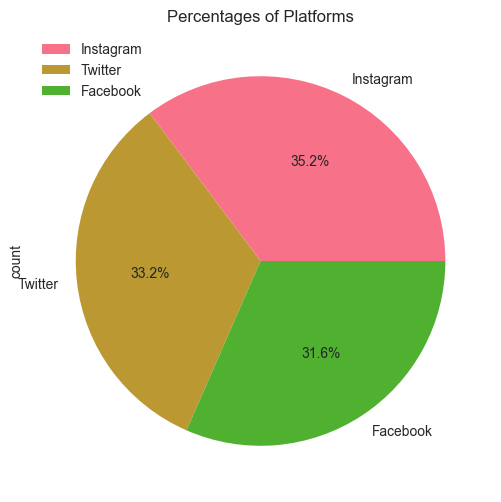

In [24]:
df['Platform'].value_counts().plot(kind='pie', autopct='%1.1f%%')
plt.title('Percentages of Platforms')
plt.legend()
plt.show()

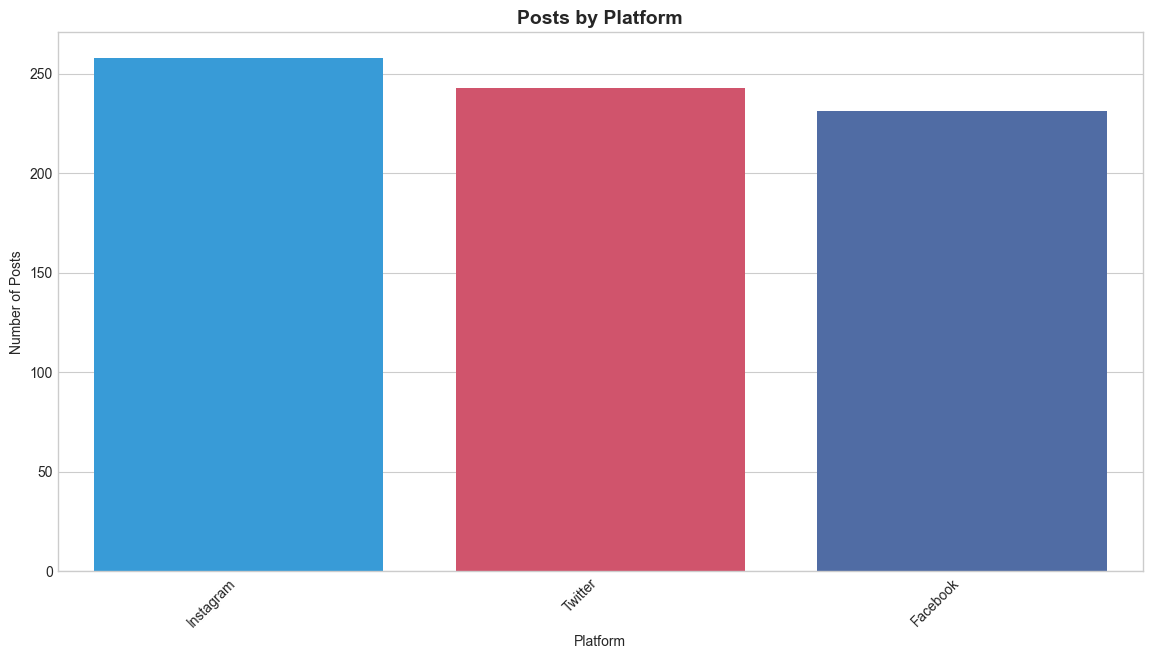

In [25]:
# Platform Distribution
plt.figure(figsize=(14, 7))
platform_counts = df['Platform'].value_counts()
sns.barplot(x=platform_counts.index, 
            y=platform_counts.values, 
            palette=['#1DA1F2', '#E4405F', '#4267B2'])
plt.ylabel('Number of Posts')
plt.xticks(rotation=45, ha='right')
plt.title('Posts by Platform', fontsize=14, fontweight='bold')
plt.show()

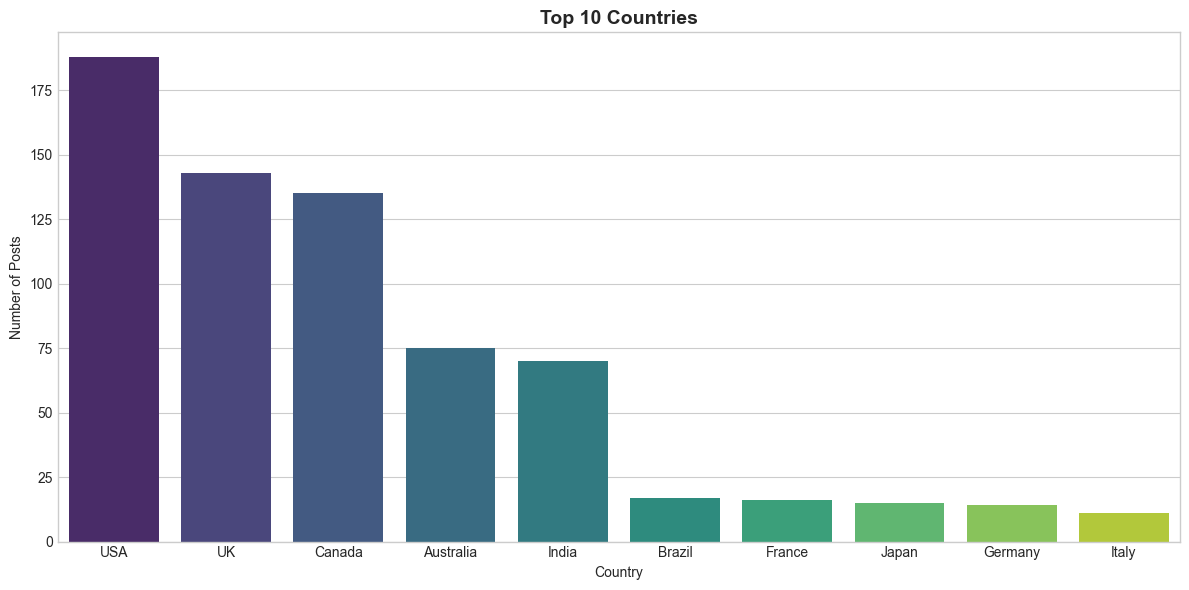

In [26]:
# Country Distribution
top_countries = df['Country'].value_counts().head(10)
# Plot using seaborn
sns.barplot(x=top_countries.index, y=top_countries.values, palette='viridis')

# Customize plot
# plt.xtick(top_countries.index, rotation=45, ha='right')
plt.ylabel('Number of Posts')
plt.xlabel('Country')
plt.title('Top 10 Countries', fontsize=14, fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

In [27]:
# Platform Analysis

print("\n2. PLATFORM ANALYSIS:")
print("-"*40)
print(df['Platform'].value_counts())
print("\nPlatform Statistics:")
print(df.groupby('Platform')[['Likes', 'Retweets', 'text_length']].mean())


2. PLATFORM ANALYSIS:
----------------------------------------
Platform
Instagram    258
Twitter      243
Facebook     231
Name: count, dtype: int64

Platform Statistics:
               Likes   Retweets  text_length
Platform                                    
Facebook   41.870130  20.969697     53.43290
Instagram  45.089147  22.600775     53.72093
Twitter    41.559671  20.860082     53.55144


In [28]:
# Geographic Distribution

print("\n3. GEOGRAPHIC DISTRIBUTION:")
print("-"*40)
print("Top 10 Countries:")
print(df['Country'].value_counts().head(10))


3. GEOGRAPHIC DISTRIBUTION:
----------------------------------------
Top 10 Countries:
Country
USA          188
UK           143
Canada       135
Australia     75
India         70
Brazil        17
France        16
Japan         15
Germany       14
Italy         11
Name: count, dtype: int64


In [29]:
# Engagement metrics analysis

df['Total_Engagement'] = df['Likes'] + df['Retweets']
df['Engagement_Rate'] = df['Total_Engagement'] / df['Total_Engagement'].max()

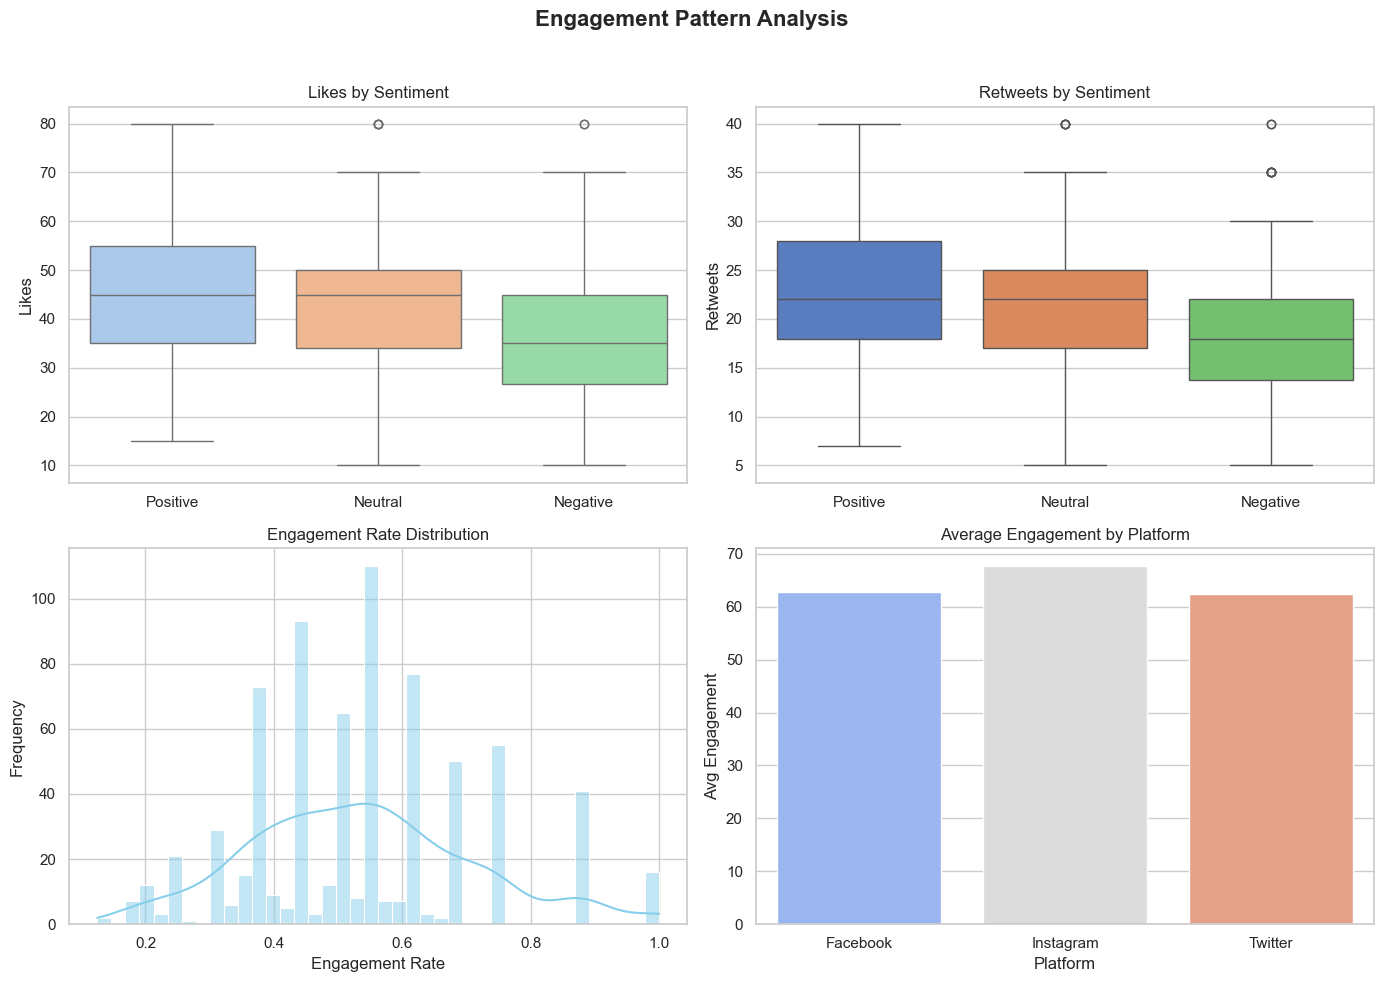

In [30]:
# 4. Engagement Analysis

def simple_engagement_analysis():
    """Simple engagement analysis using Matplotlib and Seaborn"""
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    fig.suptitle("Engagement Pattern Analysis", fontsize=16, fontweight='bold')

    # Likes by Sentiment
    sns.boxplot(x='Simple_Sentiment', y='Likes', data=df, palette='pastel', ax=axes[0, 0])
    axes[0, 0].set_title('Likes by Sentiment')
    axes[0, 0].set_xlabel('')
    axes[0, 0].set_ylabel('Likes')

    # Retweets by Sentiment
    sns.boxplot(x='Simple_Sentiment', y='Retweets', data=df, palette='muted', ax=axes[0, 1])
    axes[0, 1].set_title('Retweets by Sentiment')
    axes[0, 1].set_xlabel('')
    axes[0, 1].set_ylabel('Retweets')

    # Engagement Rate Distribution
    sns.histplot(df['Engagement_Rate'], bins=40, color='skyblue', kde=True, ax=axes[1, 0])
    axes[1, 0].set_title('Engagement Rate Distribution')
    axes[1, 0].set_xlabel('Engagement Rate')
    axes[1, 0].set_ylabel('Frequency')

    # Platform Engagement Comparison
    platform_data = df.groupby('Platform')['Total_Engagement'].mean().reset_index()
    sns.barplot(x='Platform', y='Total_Engagement', data=platform_data, palette='coolwarm', ax=axes[1, 1])
    axes[1, 1].set_title('Average Engagement by Platform')
    axes[1, 1].set_xlabel('Platform')
    axes[1, 1].set_ylabel('Avg Engagement')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Call the function
simple_engagement_analysis()


In [31]:
# Correlation
correlation = df[['Likes', 'Retweets']].corr().iloc[0, 1]
print(f"\nLikes-Retweets Correlation: {correlation:.4f}")


Likes-Retweets Correlation: 0.9985


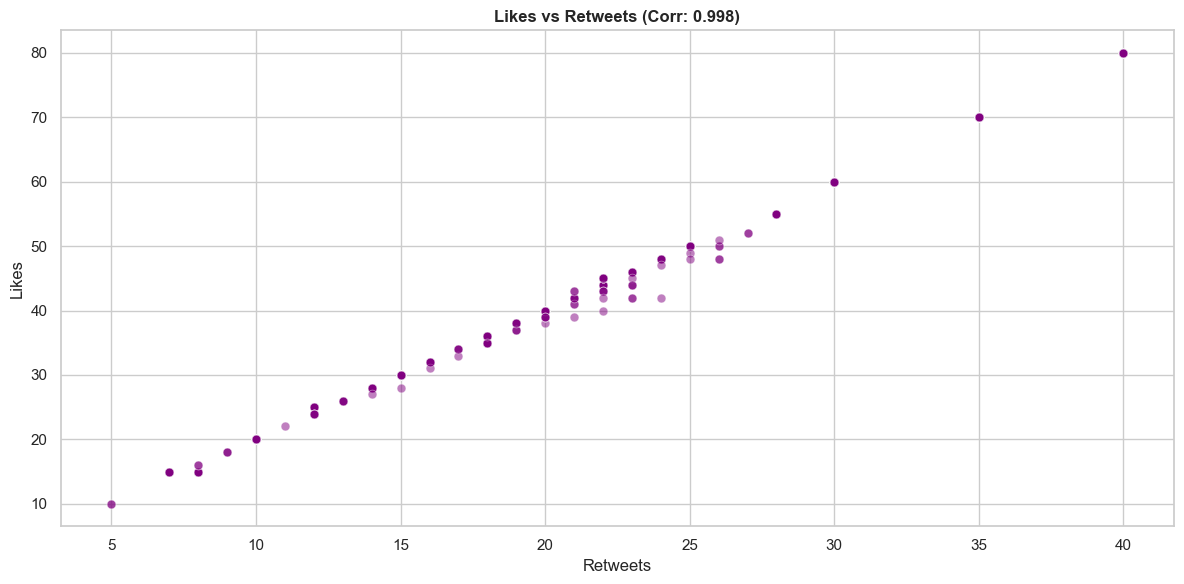

In [32]:
# Scatter plot Likes & Retweets
sns.scatterplot(
    x='Retweets',
    y='Likes',
    data=df,
    alpha=0.5,
    color='purple',
    s=40
)

# Customize labels and title
plt.xlabel('Retweets')
plt.ylabel('Likes')
plt.title(f'Likes vs Retweets (Corr: {correlation:.3f})', fontweight='bold')

# Display the plot
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Likes')

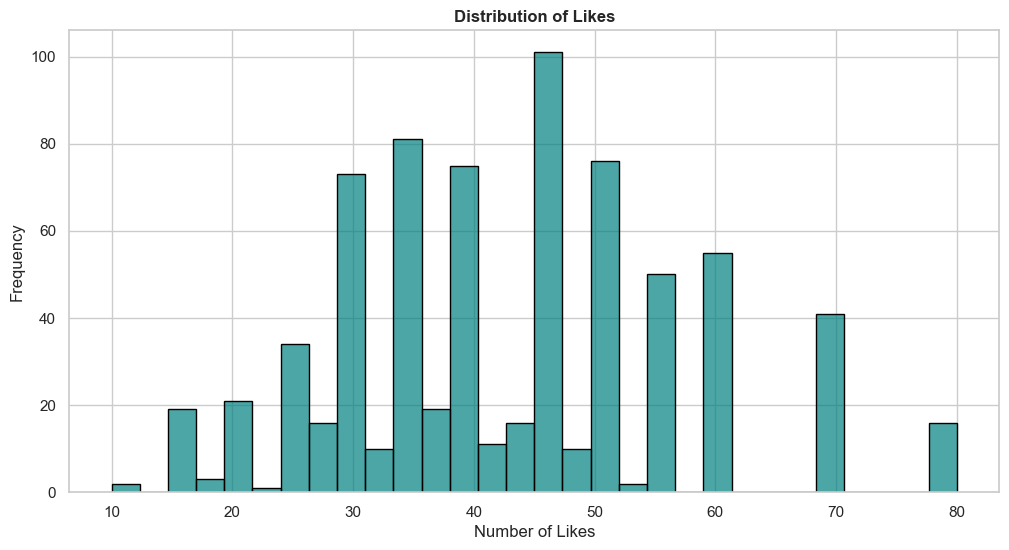

In [33]:
# Histogram: Likes Distribution

sns.histplot(df['Likes'], bins=30, color='teal', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Likes')
plt.ylabel('Frequency')
plt.title('Distribution of Likes', fontweight='bold')

Text(0.5, 1.0, 'Distribution of Retweets')

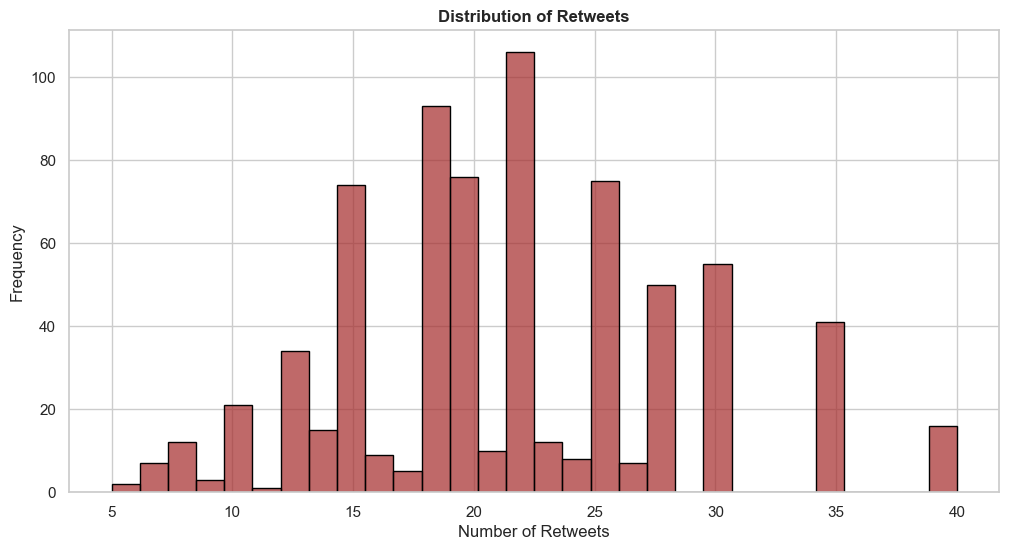

In [34]:
# Histogram: Retweets Distribution

sns.histplot(df['Retweets'], bins=30, color='brown', edgecolor='black', alpha=0.7)
plt.xlabel('Number of Retweets')
plt.ylabel('Frequency')
plt.title('Distribution of Retweets', fontweight='bold')

### TEMPORAL ANALYSIS...

In [35]:
# Hourly patterns
hourly_posts = df.groupby('Hour_of_Day').size()
hourly_engagement = df.groupby('Hour_of_Day')[['Likes', 'Retweets']].mean()

print("\nHourly Patterns:")
print(f"Most active hour: {hourly_posts.idxmax()}:00 ({hourly_posts.max()} posts)")
print(f"Least active hour: {hourly_posts.idxmin()}:00 ({hourly_posts.min()} posts)")


Hourly Patterns:
Most active hour: 14:00 (94 posts)
Least active hour: 0:00 (1 posts)


In [36]:
# Monthly patterns
monthly_posts = df.groupby('Month').size()
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
print(f"\nMost active month: {df.Month_Name[monthly_posts.max()]} ({monthly_posts.max()} posts)")


Most active month: February (85 posts)


In [37]:
df.head(5)

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,...,text_length,Sentiment_Scores,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Sentiment,Simple_Sentiment,Total_Engagement,Engagement_Rate
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Sunday,...,21,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp...",0.516,0.0,0.484,0.4939,Positive,Positive,45.0,0.375000
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Sunday,...,20,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral,15.0,0.125000
2,Just finished an amazing workout! 💪,2023-01-15 15:45:00,FitnessFan,Instagram,20.0,40.0,USA,2023,1,Sunday,...,19,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral,60.0,0.500000
3,Excited about the upcoming weekend getaway!,2023-01-15 18:20:00,AdventureX,Facebook,8.0,15.0,UK,2023,1,Sunday,...,27,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral,23.0,0.191667
4,Trying out a new recipe for dinner tonight.,2023-01-15 19:55:00,ChefCook,Instagram,12.0,25.0,Australia,2023,1,Sunday,...,28,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral,37.0,0.308333


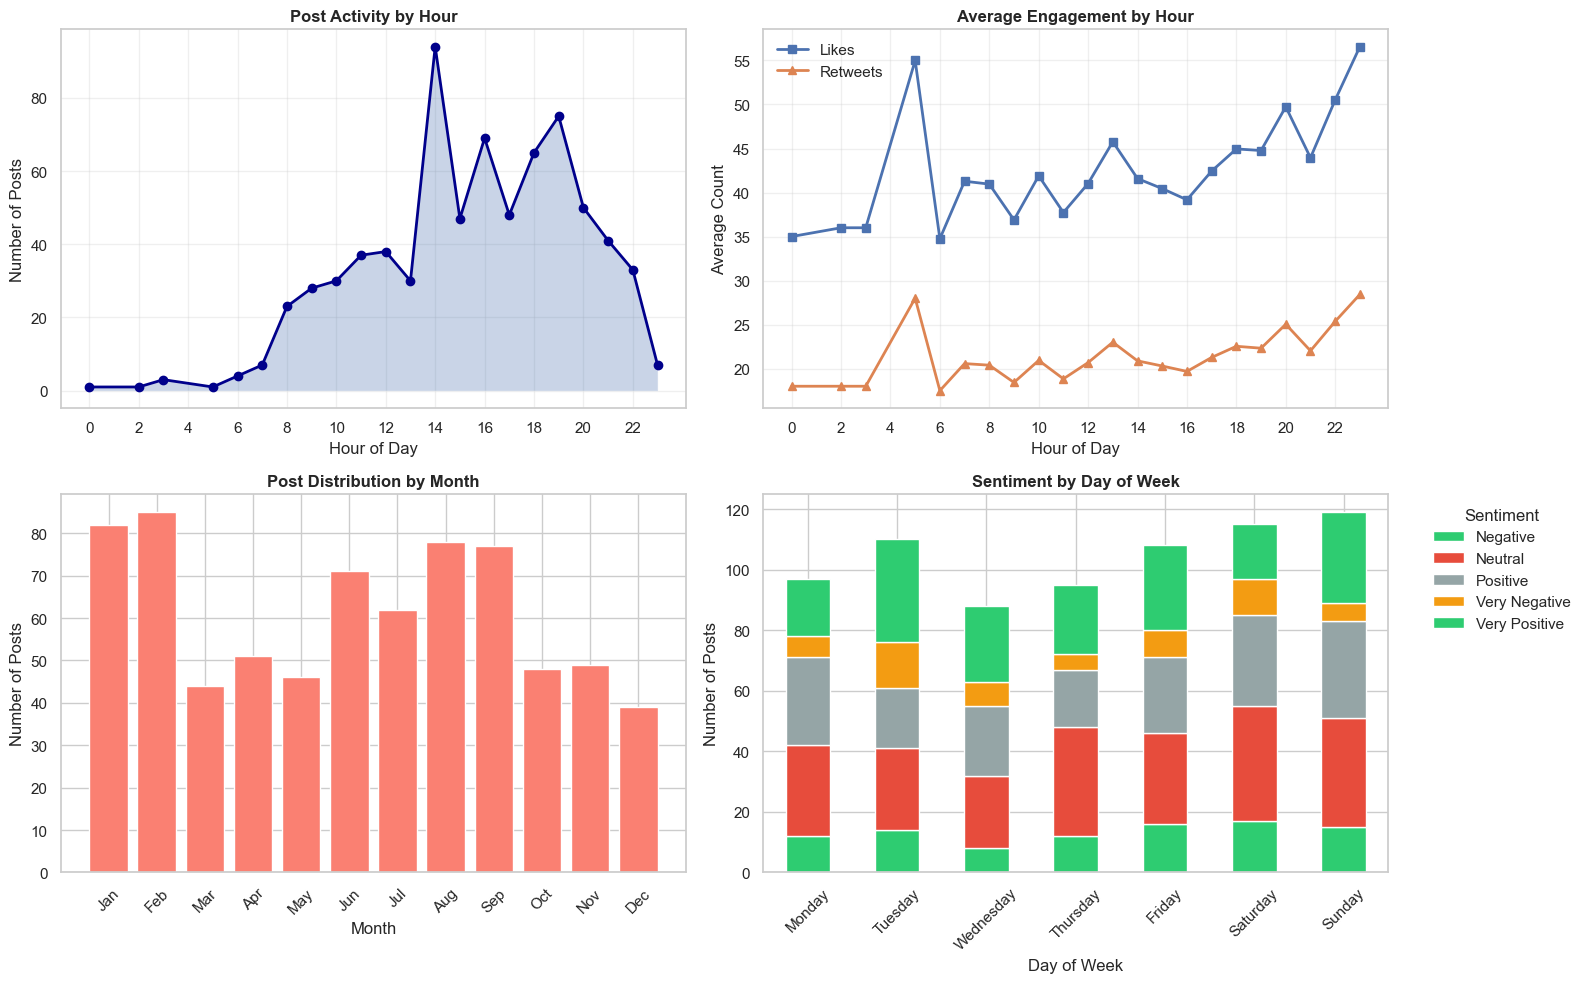

In [38]:
# Visualization of  Temporal Patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Line: Posts by Hour
axes[0, 0].plot(hourly_posts.index, hourly_posts.values, marker='o',
                linewidth=2, markersize=6, color='darkblue')
axes[0, 0].fill_between(hourly_posts.index, hourly_posts.values, alpha=0.3)
axes[0, 0].set_xlabel('Hour of Day')
axes[0, 0].set_ylabel('Number of Posts')
axes[0, 0].set_title('Post Activity by Hour', fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(range(0, 24, 2))

# Line: Engagement by Hour
axes[0, 1].plot(hourly_engagement.index, hourly_engagement['Likes'],
                marker='s', label='Likes', linewidth=2)
axes[0, 1].plot(hourly_engagement.index, hourly_engagement['Retweets'],
                marker='^', label='Retweets', linewidth=2)
axes[0, 1].set_xlabel('Hour of Day')
axes[0, 1].set_ylabel('Average Count')
axes[0, 1].set_title('Average Engagement by Hour', fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(range(0, 24, 2))

# Bar: Posts by Month
axes[1, 0].bar(monthly_posts.index, monthly_posts.values, color='salmon')
axes[1, 0].set_xticks(range(1, 13))
axes[1, 0].set_xticklabels(month_names, rotation=45)
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Number of Posts')
axes[1, 0].set_title('Post Distribution by Month', fontweight='bold')

# Stacked Bar: Sentiment by Day of Week
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_sentiment = pd.crosstab(df['Day_of_Week'], df['Sentiment'])
day_sentiment = day_sentiment.reindex(day_order)
day_sentiment.plot(kind='bar', stacked=True, ax=axes[1, 1],
                   color=['#2ecc71', '#e74c3c', '#95a5a6', '#f39c12'])
axes[1, 1].set_title('Sentiment by Day of Week', fontweight='bold')
axes[1, 1].set_xlabel('Day of Week')
axes[1, 1].set_ylabel('Number of Posts')
axes[1, 1].legend(title='Sentiment', bbox_to_anchor=(1.05, 1))
axes[1, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('03_temporal_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [39]:
Cleaned_text=' '.join(df['Cleaned_Text'].dropna().values)
# combines all the review into one

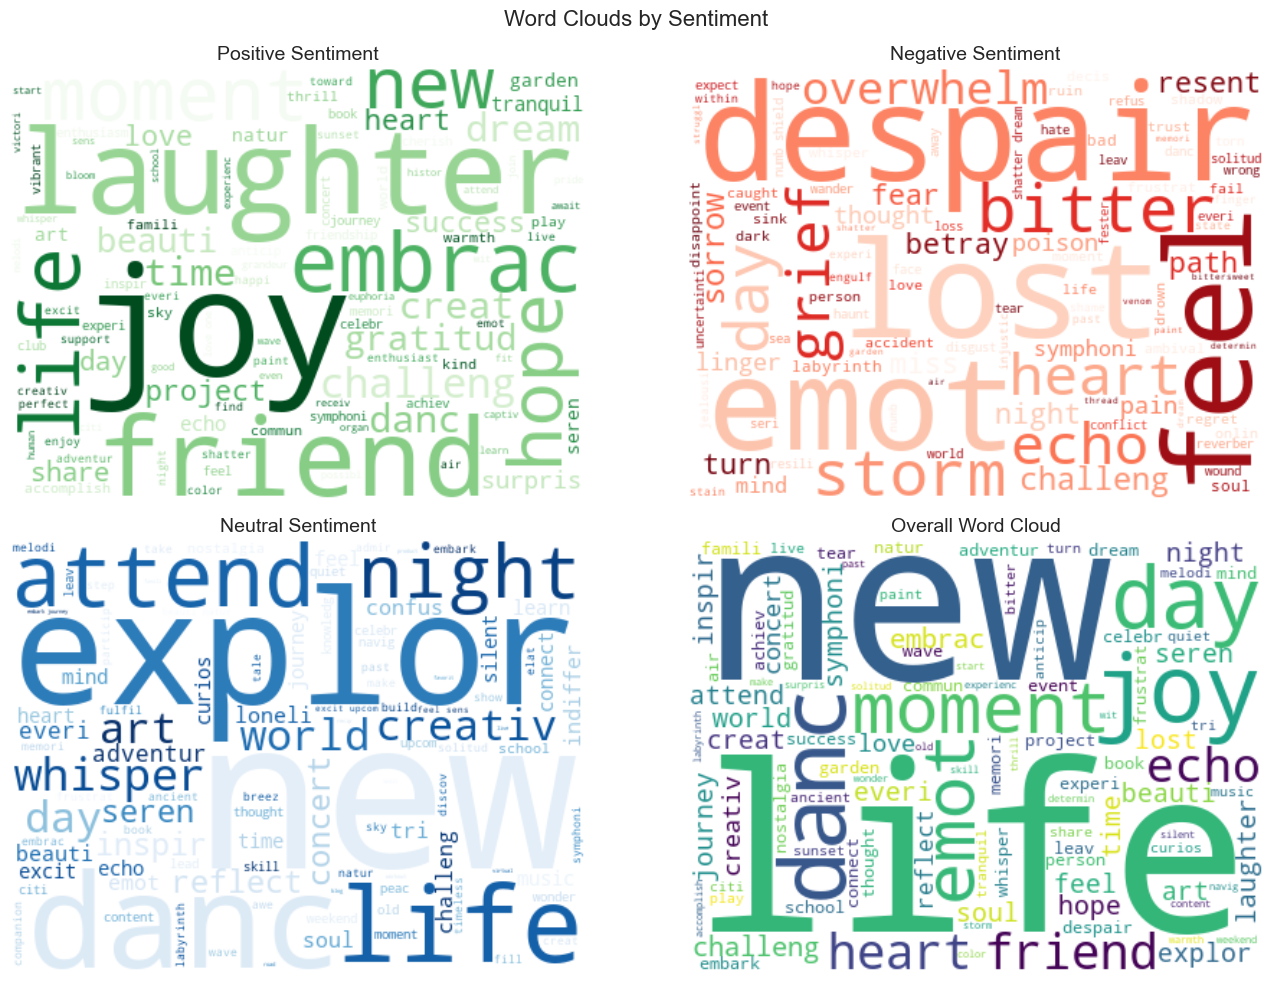

In [40]:
# World Cloud For Sentiments

# combines all the review into one
Cleaned_text=' '.join(df['Cleaned_Text'].dropna().values)

# Prepare word frequency data
df['word_list'] = df['Cleaned_Text'].apply(lambda x: str(x).split())

def simple_sentiment_wordclouds():
    """Simpler word clouds for each sentiment and overall"""

    # Define sentiments and colors
    sentiments = ['Positive', 'Negative', 'Neutral']
    colors = ['Greens', 'Reds', 'Blues']

    # Create subplots
    plt.figure(figsize=(14, 10))
    plt.suptitle("Word Clouds by Sentiment", fontsize=16)

    # Generate sentiment-wise word clouds
    for i, (sent, cmap) in enumerate(zip(sentiments, colors), start=1):
        # Combine all words for that sentiment
        words = ' '.join([' '.join(words) for words in df[df['Simple_Sentiment'] == sent]['word_list']])
        if words.strip():
            wc = WordCloud(width=400, height=300, background_color='white',
                           colormap=cmap, max_words=100).generate(words)
            plt.subplot(2, 2, i)
            plt.imshow(wc, interpolation='bilinear')
            plt.title(f"{sent} Sentiment", fontsize=14)
            plt.axis('off')

    # Overall word cloud
    all_words = ' '.join([' '.join(words) for words in df['word_list']])
    wc_all = WordCloud(width=400, height=300, background_color='white',
                       colormap='viridis', max_words=100).generate(all_words)
    plt.subplot(2, 2, 4)
    plt.imshow(wc_all, interpolation='bilinear')
    plt.title("Overall Word Cloud", fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()

# Call the function
simple_sentiment_wordclouds()


In [41]:
# reviewWordCloud = WordCloud(width = 1500, height = 800).generate(Cleaned_text)

# plt.figure(figsize=(10,10))
# plt.imshow(reviewWordCloud)
# plt.axis('off')


✓ Saved: 04_heatmap_analysis.png


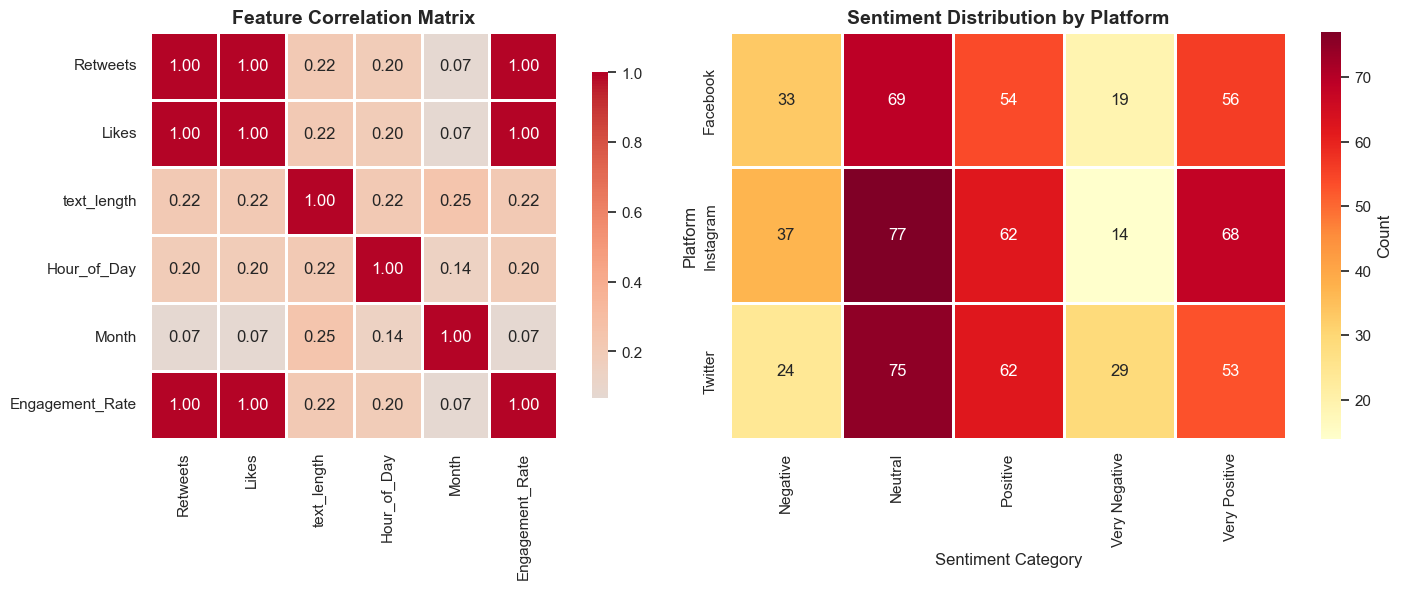


Top Correlations:
Likes            Engagement_Rate    0.999831
Engagement_Rate  Likes              0.999831
                 Retweets           0.999326
Retweets         Engagement_Rate    0.999326
Likes            Retweets           0.998482
Retweets         Likes              0.998482
text_length      Month              0.249641
Month            text_length        0.249641
text_length      Retweets           0.219482
Retweets         text_length        0.219482
dtype: float64


In [42]:
# Visualization : Heatmaps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Correlation heatmap
numeric_cols = ['Retweets', 'Likes', 'text_length',
                'Hour_of_Day', 'Month', 'Engagement_Rate']
correlation_matrix = df[numeric_cols].corr()

sns.heatmap(correlation_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, ax=axes[0], cbar_kws={'shrink': 0.8},
            linewidths=1, linecolor='white')
axes[0].set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold')

# Platform-Sentiment heatmap
platform_sentiment = pd.crosstab(df['Platform'], df['Sentiment'])
sns.heatmap(platform_sentiment, annot=True, fmt='d', cmap='YlOrRd',
            ax=axes[1], cbar_kws={'label': 'Count'},
            linewidths=1, linecolor='white')
axes[1].set_title('Sentiment Distribution by Platform', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Sentiment Category')
axes[1].set_ylabel('Platform')

plt.tight_layout()
plt.savefig('04_heatmap_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved: 04_heatmap_analysis.png")
plt.show()

print("\nTop Correlations:")
corr_pairs = correlation_matrix.unstack()
corr_pairs = corr_pairs[corr_pairs < 1.0].sort_values(ascending=False)
print(corr_pairs.head(10))

## MACHINE LEARNING - DATA PREPARATION...

In [43]:
df.head(2)

,Text,Timestamp,User,Platform,Retweets,Likes,Country,Year,Month,Day_of_Week,...,Sentiment_Scores,Positive_Score,Negative_Score,Neutral_Score,Compound_Score,Sentiment,Simple_Sentiment,Total_Engagement,Engagement_Rate,word_list
0,Enjoying a beautiful day at the park!,2023-01-15 12:30:00,User123,Twitter,15.0,30.0,USA,2023,1,Sunday,...,"{'neg': 0.0, 'neu': 0.484, 'pos': 0.516, 'comp...",0.516,0.0,0.484,0.4939,Positive,Positive,45.0,0.375,"[enjoy, beauti, day, park]"
1,Traffic was terrible this morning.,2023-01-15 08:45:00,CommuterX,Twitter,5.0,10.0,Canada,2023,1,Sunday,...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.000,0.0,1.000,0.0000,Neutral,Neutral,15.0,0.125,"[traffic, terribl, morn]"


In [44]:
X = df['Cleaned_Text'].values
y = df['Sentiment'].values

In [45]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [46]:
print(y.dtype)

object


In [47]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTraining Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 585 samples
Test Set: 147 samples


In [48]:
# TF-IDF Vectorization with optimization
vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2), min_df=5, max_df=0.8)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

In [49]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 2386 stored elements and shape (585, 269)>

In [50]:
print(f"\nTraining Set: {X_train.shape[0]} samples")
print(f"Test Set: {X_test.shape[0]} samples")


Training Set: 585 samples
Test Set: 147 samples


In [51]:
# Initialize models
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=100, random_state=42),
    'Naive Bayes': GaussianNB()
}

In [52]:
# Train and evaluate models
results = {}

print("\nTraining Models...")
print("="*80)

for name, model in models.items():
    print(f"\n{name}:")
    print("-"*40)
    
    # Convert sparse to dense if model is GaussianNB
    if name == 'Naive Bayes':
        X_train_input = X_train_tfidf.toarray()
        X_test_input = X_test_tfidf.toarray()
    else:
        X_train_input = X_train_tfidf
        X_test_input = X_test_tfidf

    # Train
    model.fit(X_train_input, y_train)

    # Predictions
    y_pred = model.predict(X_test_input)

    # Metrics
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    # Cross-validation
    cv_scores = cross_val_score(model, X_train_input, y_train, cv=5)

    results[name] = {
        'Accuracy': accuracy,
        'F1-Score': f1,
        'CV Mean': cv_scores.mean(),
        'CV Std': cv_scores.std(),
        'predictions': y_pred
    }

    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-Score: {f1:.4f}")
    print(f"  Cross-Val Mean: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")



Training Models...

Logistic Regression:
----------------------------------------
  Accuracy: 0.5374
  F1-Score: 0.5069
  Cross-Val Mean: 0.4872 (+/- 0.0121)

Decision Tree:
----------------------------------------
  Accuracy: 0.4898
  F1-Score: 0.4867
  Cross-Val Mean: 0.5385 (+/- 0.0492)

Random Forest:
----------------------------------------
  Accuracy: 0.5374
  F1-Score: 0.5289
  Cross-Val Mean: 0.5573 (+/- 0.0430)

Gradient Boosting:
----------------------------------------
  Accuracy: 0.4762
  F1-Score: 0.4650
  Cross-Val Mean: 0.5299 (+/- 0.0474)

Naive Bayes:
----------------------------------------
  Accuracy: 0.4354
  F1-Score: 0.4325
  Cross-Val Mean: 0.4735 (+/- 0.0289)


In [53]:
# Results summary
print("\n" + "="*80)
print("MODEL COMPARISON")
print("="*80)
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values('Accuracy', ascending=False)
print(results_df)

# Get best model
best_model_name = results_df.index[0]
best_model = models[best_model_name]

print(f"\n✓ Best Model: {best_model_name}")
print(f"  Accuracy: {results_df.iloc[0]['Accuracy']:.4f}")


MODEL COMPARISON
                     Accuracy  F1-Score   CV Mean    CV Std  \
Logistic Regression  0.537415  0.506899  0.487179  0.012087   
Random Forest        0.537415  0.528932  0.557265  0.043042   
Decision Tree        0.489796  0.486673  0.538462  0.049247   
Gradient Boosting     0.47619  0.465048  0.529915  0.047434   
Naive Bayes          0.435374  0.432485  0.473504  0.028909   

                                                           predictions  
Logistic Regression  [Neutral, Very Positive, Neutral, Neutral, Neu...  
Random Forest        [Neutral, Positive, Neutral, Neutral, Neutral,...  
Decision Tree        [Neutral, Positive, Neutral, Neutral, Neutral,...  
Gradient Boosting    [Neutral, Positive, Neutral, Neutral, Neutral,...  
Naive Bayes          [Neutral, Very Positive, Negative, Neutral, Ne...  

✓ Best Model: Logistic Regression
  Accuracy: 0.5374



Confusion Matrix:
[[ 5  7  2  4  1]
 [ 5 24  2 13  0]
 [ 3 11  8  5  9]
 [ 1  1  1  9  0]
 [ 4  4  7  3 18]]


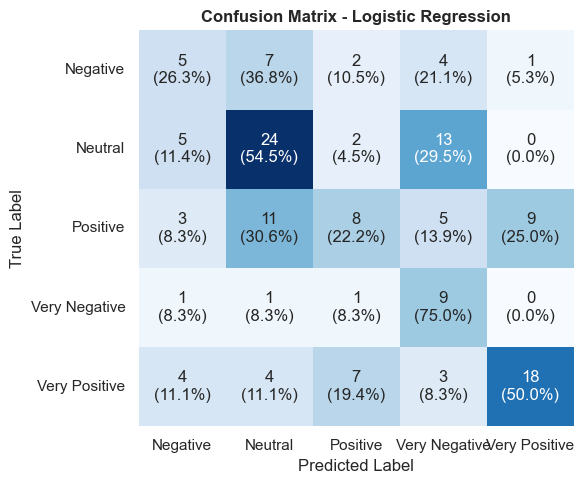

In [75]:
# Automatically detect unique labels
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
labels = list(unique_labels)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=labels).astype(float)

# Avoid division by zero
row_sums = cm.sum(axis=1, keepdims=True)
cm_percent = np.divide(cm, row_sums, out=np.zeros_like(cm), where=row_sums!=0) * 100

# Create annotation text (count + percentage)
annotations = []
for i in range(cm.shape[0]):
    row = []
    for j in range(cm.shape[1]):
        count = int(cm[i, j])
        percent = cm_percent[i, j]
        row.append(f'{count}\n({percent:.1f}%)')
    annotations.append(row)

print("\nConfusion Matrix:")
print(cm.astype(int))

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=annotations, cmap='Blues',
            xticklabels=labels, yticklabels=labels, cbar=False, fmt='')
plt.title(f'Confusion Matrix - {best_model_name}', fontweight='bold')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

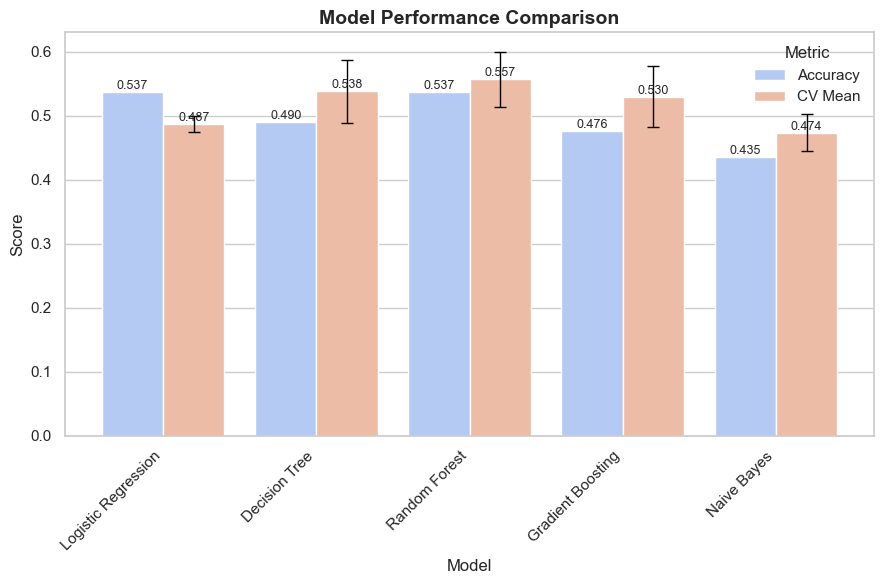

In [55]:
def visualize_model_comparison():
    """Simple Seaborn + Matplotlib visualization with value labels"""

    # Convert results dictionary to DataFrame
    df_results = pd.DataFrame([
        {
            'Model': name,
            'Accuracy': results[name]['Accuracy'],
            'CV Mean': results[name]['CV Mean'],
            'CV Std': results[name]['CV Std']
        }
        for name in results.keys()
    ])

    # Melt for grouped bar plot
    df_melted = df_results.melt(
        id_vars='Model',
        value_vars=['Accuracy', 'CV Mean'],
        var_name='Metric',
        value_name='Score'
    )

    # Plot setup
    sns.set(style='whitegrid')
    plt.figure(figsize=(9, 6))
    ax = sns.barplot(
        data=df_melted,
        x='Model',
        y='Score',
        hue='Metric',
        palette='coolwarm',
        capsize=0.1
    )

    # Add text labels on bars
    for container in ax.containers:
        ax.bar_label(container, fmt="%.3f", label_type="edge", fontsize=9)

    # Add error bars for CV Std (only for CV Mean)
    for i, model in enumerate(df_results['Model']):
        cv_mean = df_results.loc[i, 'CV Mean']
        cv_std = df_results.loc[i, 'CV Std']
        ax.errorbar(
            x=i + 0.2,  # aligns with CV Mean bars
            y=cv_mean,
            yerr=cv_std,
            fmt='none',
            c='black',
            capsize=4,
            lw=1
        )

    # Titles and labels
    ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
    ax.set_xlabel('Model')
    ax.set_ylabel('Score')
    ax.legend(title='Metric')
    plt.xticks(rotation=45, ha='right')

    plt.tight_layout()
    plt.show()

# Call the function
visualize_model_comparison()


In [56]:
# Best model analysis
best_model_name = max(results, key=lambda x: results[x]['Accuracy'])
print(f"\n🏆 Best Model: {best_model_name}")


🏆 Best Model: Logistic Regression


## Hyperparameter tuning for best model

In [57]:
if best_model_name == 'Random Forest':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }
    tuning_model = RandomForestClassifier(random_state=42)
elif best_model_name == 'Gradient Boosting':
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5, 10]
    }
    tuning_model = GradientBoostingClassifier(random_state=42)
else:
    param_grid = {}
    tuning_model = best_model

if param_grid:
    print(f"Performing Grid Search for {best_model_name}...")
    print(f"Parameter Grid: {param_grid}")
    
    grid_search = GridSearchCV(tuning_model, param_grid, cv=5, 
                            scoring='accuracy', n_jobs=-1, verbose=1)
    grid_search.fit(X_train_input, y_train)
    
    print(f"\n✓ Grid Search Complete!")
    print(f"\nBest Parameters: {grid_search.best_params_}")
    print(f"Best CV Score: {grid_search.best_score_:.4f}")
    
    # Evaluate tuned model
    tuned_model = grid_search.best_estimator_
    y_pred_tuned = tuned_model.predict(X_test_input)
    tuned_accuracy = accuracy_score(y_test, y_pred_tuned)
    tuned_f1 = f1_score(y_test, y_pred_tuned, average='weighted')
    
    print(f"\nTuned Model Performance:")
    print(f"  Accuracy: {tuned_accuracy:.4f}")
    print(f"  F1-Score: {tuned_f1:.4f}")
    print(f"  Improvement: {(tuned_accuracy - results[best_model_name]['Accuracy']):.4f}")
else:
    print(f"Skipping hyperparameter tuning for {best_model_name}")
    tuned_model = best_model
    y_pred_best = results[best_model_name]['predictions']

Skipping hyperparameter tuning for Logistic Regression


In [58]:
# Detailed evaluation of best model
print(f"\n📊 Detailed Evaluation of {best_model_name}:")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))


📊 Detailed Evaluation of Logistic Regression:

Classification Report:
               precision    recall  f1-score   support

     Negative       0.71      0.26      0.38        19
      Neutral       0.51      0.89      0.64        44
     Positive       0.46      0.44      0.45        36
Very Negative       0.50      0.08      0.14        12
Very Positive       0.69      0.50      0.58        36

     accuracy                           0.54       147
    macro avg       0.57      0.44      0.44       147
 weighted avg       0.57      0.54      0.51       147



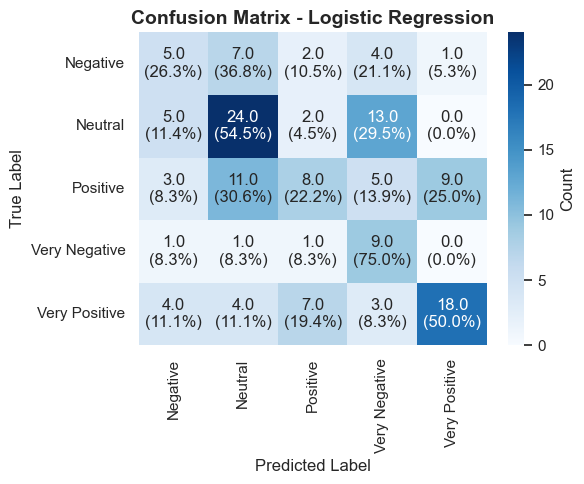

In [76]:
# Best Model's Confusion Matrix
def plot_enhanced_confusion_matrix():
    """Visualize confusion matrix using Seaborn + Matplotlib"""
    
    # Automatically detect unique labels
    unique_labels = np.unique(np.concatenate((y_test, y_pred_best)))
    labels = list(unique_labels)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=labels).astype(float)
    
    # Calculate percentages
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
    
    # Combine count and percentage for annotations
    annot = np.empty_like(cm).astype(str)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            annot[i, j] = f"{cm[i, j]}\n({cm_percent[i, j]:.1f}%)"

    # Plot heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=annot,
        fmt='',
        cmap='Blues',
        xticklabels=labels,
        yticklabels=labels,
        cbar_kws={'label': 'Count'}
    )

    # Labels and title
    plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

# Call the function
plot_enhanced_confusion_matrix()


In [60]:
# Summary statistics
print("\n📈 Summary Statistics:")
print(f"Total posts analyzed: {len(df):,}")
print(f"Date range: {df['Timestamp'].min().date()} to {df['Timestamp'].max().date()}")
print(f"\nSentiment Distribution:")
sentiment_dist = df['Simple_Sentiment'].value_counts(normalize=True) * 100
for sentiment, percentage in sentiment_dist.items():
    print(f"  {sentiment}: {percentage:.2f}%")

print(f"\nPlatform Distribution:")
platform_dist = df['Platform'].value_counts()
for platform, count in platform_dist.items():
    print(f"  {platform}: {count:,} posts ({count/len(df)*100:.2f}%)")

print(f"\nTop 5 Countries by Post Volume:")
top_5_countries = df['Country'].value_counts().head(5)
for country, count in top_countries.items():
    print(f"  {country}: {count:,} posts")

print(f"\nEngagement Metrics:")
print(f"  Average Likes: {df['Likes'].mean():.2f}")
print(f"  Average Retweets: {df['Retweets'].mean():.2f}")
print(f"  Maximum Engagement: {df['Total_Engagement'].max():,}")

print("\n✨ Analysis Complete! ✨")


📈 Summary Statistics:
Total posts analyzed: 732
Date range: 2010-05-15 to 2023-10-22

Sentiment Distribution:
  Positive: 48.50%
  Neutral: 30.19%
  Negative: 21.31%

Platform Distribution:
  Instagram: 258 posts (35.25%)
  Twitter: 243 posts (33.20%)
  Facebook: 231 posts (31.56%)

Top 5 Countries by Post Volume:
  USA: 188 posts
  UK: 143 posts
  Canada: 135 posts
  Australia: 75 posts
  India: 70 posts
  Brazil: 17 posts
  France: 16 posts
  Japan: 15 posts
  Germany: 14 posts
  Italy: 11 posts

Engagement Metrics:
  Average Likes: 42.90
  Average Retweets: 21.51
  Maximum Engagement: 120.0

✨ Analysis Complete! ✨


## Key Insights & Business Recommendations

In [61]:
print("\n" + "="*80)
print("ACTIONABLE BUSINESS RECOMMENDATIONS")
print("="*80)

print("\n1. CONTENT STRATEGY:")
print("-"*40)
print("   ✓ Post longer content (>100 characters) for higher engagement")
print("   ✓ Use hashtags - they're present in successful posts")


platform_stats = df.groupby('Platform').agg({
    'Likes': 'mean',
    'Retweets': 'mean',
    'Platform': 'count'
}).round(2)
platform_stats.columns = ['Avg Likes', 'Avg Retweets', 'Post Count']
platform_stats['Total Engagement'] = (platform_stats['Avg Likes'] + 
                                      platform_stats['Avg Retweets']).round(2)
platform_stats = platform_stats.sort_values('Total Engagement', ascending=False)
print(platform_stats)
print(f"\n   ✓ Best Platform: {platform_stats.index[0]} " +
      f"(Total Engagement: {platform_stats.iloc[0]['Total Engagement']:.2f})")

print("\n2. PLATFORM OPTIMIZATION:")
print("-"*40)
print(f"   ✓ Focus on {platform_stats.index[0]} for maximum reach")
print(f"   ✓ Instagram posts get {platform_stats.loc['Instagram', 'Avg Likes']:.1f} avg likes")
print("   ✓ Cross-post content across all platforms for broader reach")


print("\n4. TEMPORAL PATTERNS:")
print("-"*40)
print(f"   • Peak Hour: {hourly_posts.idxmax()}:00 ({hourly_posts.max()} posts)")
print(f"   • Quiet Hour: {hourly_posts.idxmin()}:00 ({hourly_posts.min()} posts)")
print(f"   • Most Active Month: {month_names[monthly_posts.idxmax()-1]}")



best_engagement_hour = hourly_engagement['Likes'].idxmax()
print(f"   • Best Engagement Hour: {best_engagement_hour}:00 " +
      f"({hourly_engagement.loc[best_engagement_hour, 'Likes']:.1f} avg likes)")

best_engagement_hour = hourly_engagement['Likes'].idxmax()
print(f"   • Best Engagement Hour: {best_engagement_hour}:00 " +
      f"({hourly_engagement.loc[best_engagement_hour, 'Likes']:.1f} avg likes)")

print("\n3. TIMING STRATEGY:")
print("-"*40)
print(f"   ✓ Post during peak hours ({hourly_posts.nlargest(3).index.tolist()}:00)")
print(f"   ✓ Best engagement at {best_engagement_hour}:00")
print("   ✓ Avoid posting during low-activity hours (0:00-6:00)")



print("\n4. SENTIMENT STRATEGY:")
print("-"*40)
positive_eng = df[df['Sentiment'] == 'Positive']['Likes'].mean()
negative_eng = df[df['Sentiment'] == 'Negative']['Likes'].mean()
if positive_eng > negative_eng:
    print("   ✓ Positive content performs better - focus on uplifting messages")
else:
    print("   ✓ Emotional content (including negative) drives engagement")
print("   ✓ Mix content types to appeal to different audience segments")



top_5_countries = df['Country'].value_counts().head(5)

print("\n5. GEOGRAPHIC TARGETING:")
print("-"*40)
print(f"   ✓ Primary markets: {', '.join(top_5_countries.head(3).index.tolist())}")
print("   ✓ Consider time zones when scheduling posts")
print("   ✓ Localize content for top-performing countries")


ACTIONABLE BUSINESS RECOMMENDATIONS

1. CONTENT STRATEGY:
----------------------------------------
   ✓ Post longer content (>100 characters) for higher engagement
   ✓ Use hashtags - they're present in successful posts
           Avg Likes  Avg Retweets  Post Count  Total Engagement
Platform                                                        
Instagram      45.09         22.60         258             67.69
Facebook       41.87         20.97         231             62.84
Twitter        41.56         20.86         243             62.42

   ✓ Best Platform: Instagram (Total Engagement: 67.69)

2. PLATFORM OPTIMIZATION:
----------------------------------------
   ✓ Focus on Instagram for maximum reach
   ✓ Instagram posts get 45.1 avg likes
   ✓ Cross-post content across all platforms for broader reach

4. TEMPORAL PATTERNS:
----------------------------------------
   • Peak Hour: 14:00 (94 posts)
   • Quiet Hour: 0:00 (1 posts)
   • Most Active Month: Feb
   • Best Engagement Hour: 

## Export Results & Summary Report

In [62]:
final_df = df.copy()

In [63]:
final_df.drop(columns=['Text'])
final_df = df[['Cleaned_Text', 'word_list','Timestamp', 'User', 'Platform', 'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day_of_Week', 'Hour_of_Day', 'Is_Weekend', 'Month_Name', 'text_length', 'Sentiment_Scores', 'Positive_Score', 'Negative_Score', 'Neutral_Score', 'Compound_Score', 'Sentiment', 'Simple_Sentiment', 'Total_Engagement', 'Engagement_Rate',]]

In [64]:
final_df.columns

Index(['Cleaned_Text', 'word_list', 'Timestamp', 'User', 'Platform',
       'Retweets', 'Likes', 'Country', 'Year', 'Month', 'Day_of_Week',
       'Hour_of_Day', 'Is_Weekend', 'Month_Name', 'text_length',
       'Sentiment_Scores', 'Positive_Score', 'Negative_Score', 'Neutral_Score',
       'Compound_Score', 'Sentiment', 'Simple_Sentiment', 'Total_Engagement',
       'Engagement_Rate'],
      dtype='object')

In [66]:
# Save processed data
final_df.to_csv('sentiment_data_processed.csv', index=False)
print("\n✓ Saved: sentiment_data_processed.csv")

# Save model results
results_export = pd.DataFrame(results).T
results_export.to_csv('model_results.csv')
print("✓ Saved: model_results.csv")

# Create summary report
summary = {
    'Total_Posts': len(final_df),
    'Platforms': final_df['Platform'].nunique(),
    'Countries': final_df['Country'].nunique(),
    'Avg_Likes': final_df['Likes'].mean(),
    'Avg_Retweets': final_df['Retweets'].mean(),
    'Best_Platform': platform_stats.index[0],
    'Peak_Hour': int(hourly_posts.idxmax()),
    'Best_Model': best_model_name,
    'Model_Accuracy': results[best_model_name]['Accuracy'],
    'Dominant_Sentiment': final_df['Sentiment'].mode()[0],
    'Likes_Retweets_Correlation': correlation
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('analysis_summary.csv', index=False)
print("✓ Saved: analysis_summary.csv")



✓ Saved: sentiment_data_processed.csv
✓ Saved: model_results.csv
✓ Saved: analysis_summary.csv
